# Analysis of ChIP-seq simulation

See 2023_chips for scripts.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [2]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [3]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

,Modification,Model,k,theta,prc_rate,f,s
0,H3K27ac,/home/jetbrains/data/2023_chips/models/H3K27ac...,9.698845,28.720036,1.0,0.016691,0.543023
1,H3K27me3,/home/jetbrains/data/2023_chips/models/H3K27me...,7.710403,32.211166,1.0,0.003799,0.186056
2,H3K36me3,/home/jetbrains/data/2023_chips/models/H3K36me...,8.121823,31.384718,1.0,0.021185,0.649353
3,H3K4me1,/home/jetbrains/data/2023_chips/models/H3K4me1...,7.084311,33.604404,1.0,0.016509,0.742254
4,H3K4me3,/home/jetbrains/data/2023_chips/models/H3K4me3...,5.655991,37.608902,1.0,0.005437,0.738595


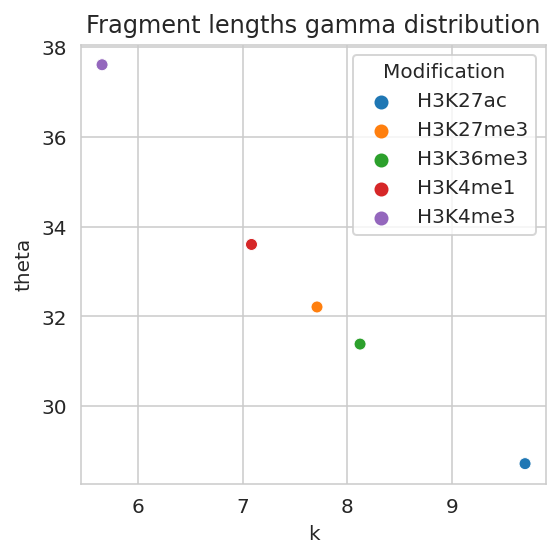

In [4]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

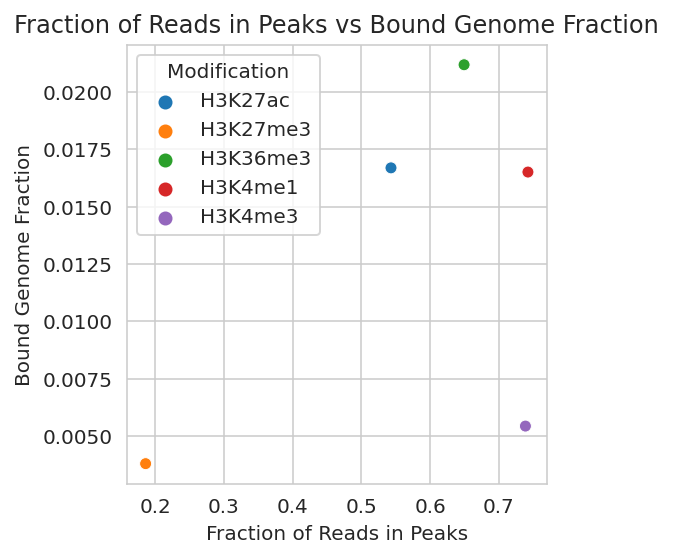

In [5]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [7]:
# original_peaks = {
#     'H3K4me3': PATH + '/peaks/H3K4me3_100_0.05_3.peak',
#     'H3K27ac': PATH + '/peaks/H3K27ac_100_0.05_3.peak',
#     'H3K4me1': PATH + '/peaks/H3K4me1_100_0.05_3.peak',
#     'H3K27me3' : PATH + '/peaks/H3K27me3_100_0.05_3.peak',
#     'H3K36me3': PATH + '/peaks/H3K36me3_100_0.05_3.peak',
# }
# 
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [8]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [9]:
from itertools import product
# Modification Mult Library I TruePeaksFile TruePeaks TrueLength Tool PeaksFile Fdr Peaks Length PrecisionP RecallP Intersection
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], 
            range(1, N + 1), 
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 0:
            df_fdr.loc[len(df_fdr)] = (res[0], m, n, mult)
    return df_fdr

In [83]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))
df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))
df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))
df_span = load_peaks(PATH + '/span', '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

df = pd.concat([df_macs2, df_macs2broad, df_span, df_sicer]).reset_index(drop=True)
df.sample(5)

0it [00:00, ?it/s]

MACS2 120


0it [00:00, ?it/s]

MACS2 broad 120


0it [00:00, ?it/s]

SICER 120


0it [00:00, ?it/s]

SPAN 120


,file,modification,n,multiplier,tool
280,/home/jetbrains/data/2023_chips/span/H3K4me1_c...,H3K4me1,1,0.7,SPAN
417,/home/jetbrains/data/2023_chips/sicer/H3K4me1_...,H3K4me1,5,0.5,SICER
229,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,3,0.5,MACS2 broad
219,/home/jetbrains/data/2023_chips/macs2/H3K36me3...,H3K36me3,5,0.1,MACS2 broad
420,/home/jetbrains/data/2023_chips/sicer/H3K27me3...,H3K27me3,1,0.7,SICER


## Estimate overlap with ground truth peaks

In [84]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(df[['file', 'modification', 'n']].iterrows()):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    true_overlap = lines(tf)
    !bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    overlap = lines(tf)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))
    
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 
                             'true_overlap', 'overlap', 'overlap_len'])
for c in t.columns:
    df[c] = list(t[c])
del t
df.sample(5)

0it [00:00, ?it/s]

,file,modification,n,multiplier,tool,true_peaks_file,true_peaks,true_length,peaks,length,true_overlap,overlap,overlap_len
444,/home/jetbrains/data/2023_chips/sicer/H3K36me3...,H3K36me3,2,0.7,SICER,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,6942900,462,6755538.0,450,462,6701429
19,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,5,0.1,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,455244,249,202611.0,177,240,192932
324,/home/jetbrains/data/2023_chips/span/H3K36me3_...,H3K36me3,2,0.7,SPAN,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,6942900,614,6399680.0,434,614,6377349
395,/home/jetbrains/data/2023_chips/sicer/H3K27ac_...,H3K27ac,4,0.1,SICER,/home/jetbrains/data/2023_chips/fastq/H3K27ac_...,500,522516,1304,2042296.0,186,186,324991
59,/home/jetbrains/data/2023_chips/macs2/H3K4me1_...,H3K4me1,5,0.1,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K4me1_...,500,590213,0,0.0,0,0,0


In [85]:
df['Precision'] = df['overlap'] / df['peaks']
df['Recall'] = df['true_overlap'] / df['true_peaks']

df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['Precision'], df['Recall'])]
df['Jaccard'] = df['overlap_len'] / (df['true_length'] + df['length'] - df['overlap_len'])

df['quality'] = [f'{int(m * 100)}%' for m in df['multiplier']]

df.sample(5)

,file,modification,n,multiplier,tool,true_peaks_file,true_peaks,true_length,peaks,length,true_overlap,overlap,overlap_len,Precision,Recall,F1,Jaccard,quality
297,/home/jetbrains/data/2023_chips/span/H3K4me1_c...,H3K4me1,5,0.5,SPAN,/home/jetbrains/data/2023_chips/fastq/H3K4me1_...,500,590213,403,562204.0,403,403,531581,1.000000,0.806,0.892580,0.856234,50%
398,/home/jetbrains/data/2023_chips/sicer/H3K27ac_...,H3K27ac,5,0.2,SICER,/home/jetbrains/data/2023_chips/fastq/H3K27ac_...,500,590798,1253,2061947.0,302,302,488482,0.241022,0.604,0.344552,0.225704,20%
400,/home/jetbrains/data/2023_chips/sicer/H3K4me1_...,H3K4me1,1,0.7,SICER,/home/jetbrains/data/2023_chips/fastq/H3K4me1_...,500,601094,655,1704145.0,470,471,590151,0.719084,0.940,0.814834,0.344094,70%
462,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,1,0.2,SICER,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,1000,7012777,719,5983881.0,660,694,5793208,0.965229,0.660,0.783953,0.804227,20%
326,/home/jetbrains/data/2023_chips/span/H3K36me3_...,H3K36me3,2,0.2,SPAN,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,6942900,413,5634618.0,309,413,5627824,1.000000,0.618,0.763906,0.809795,20%


# Peaks number and lengths

In [86]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

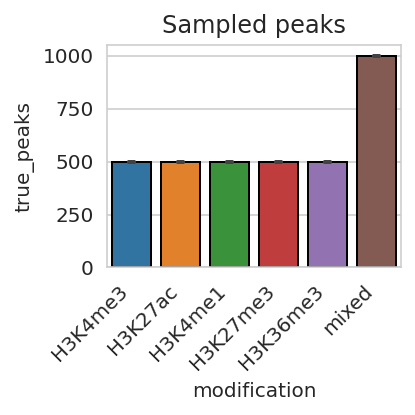

In [87]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df, x="modification", y="true_peaks",
           capsize=.1, errwidth=2, edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [88]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification
0,1380,H3K4me3
1,363,H3K4me3
2,1700,H3K4me3
3,550,H3K4me3
4,314,H3K4me3
...,...,...
99995,12199,H3K36me3
99996,14199,H3K36me3
99997,1999,H3K36me3
99998,5599,H3K36me3


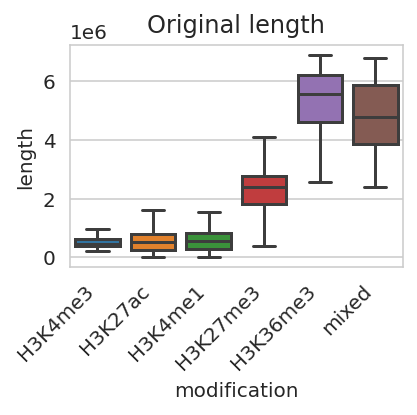

In [89]:
fig = plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

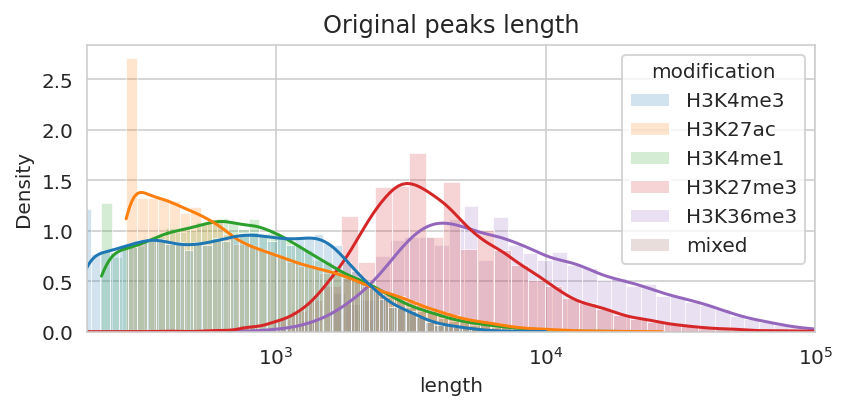

In [90]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [91]:
ts = []
for _, (m, file) in df[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification
0,493,H3K4me3
1,1903,H3K4me3
2,1592,H3K4me3
3,314,H3K4me3
4,1271,H3K4me3
...,...,...
279995,22599,mixed
279996,329,mixed
279997,6799,mixed
279998,3399,mixed


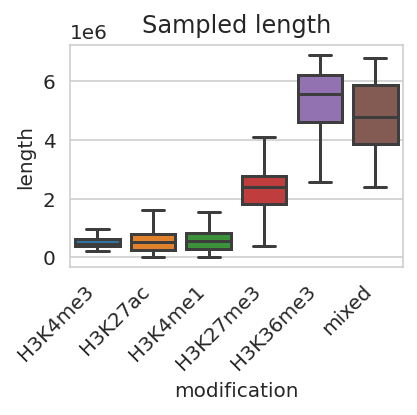

In [92]:
fig = plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

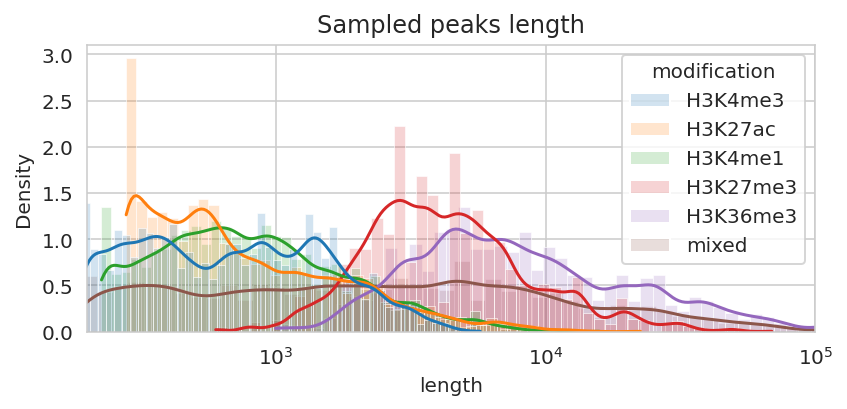

In [93]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

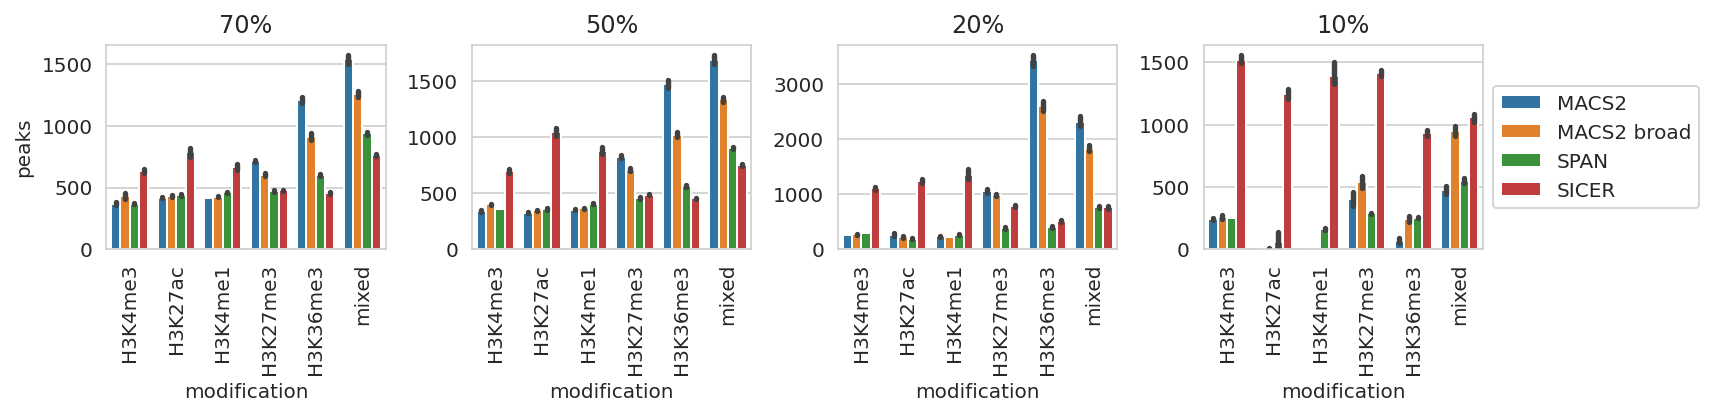

In [94]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 3:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [95]:
ts = []
for _, (m, q, tool, file) in df[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification,quality,tool
0,971.0,H3K4me3,70%,MACS2
1,1072.0,H3K4me3,70%,MACS2
2,765.0,H3K4me3,70%,MACS2
3,2415.0,H3K4me3,70%,MACS2
4,2308.0,H3K4me3,70%,MACS2
...,...,...,...,...
332406,1599.0,mixed,10%,SICER
332407,3399.0,mixed,10%,SICER
332408,599.0,mixed,10%,SICER
332409,5999.0,mixed,10%,SICER


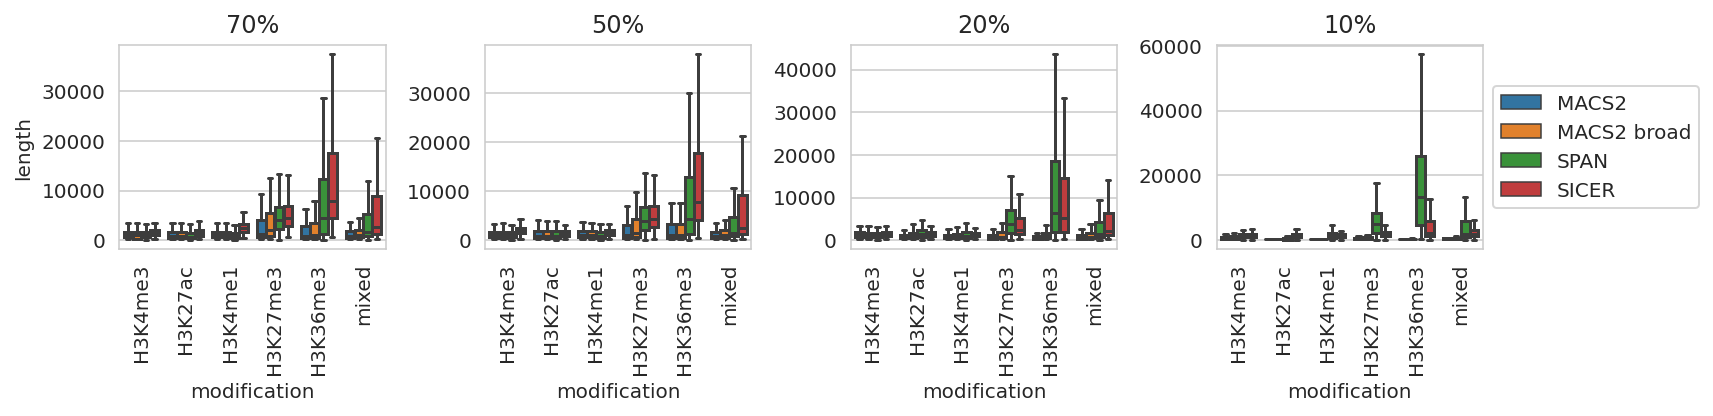

In [96]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 3:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

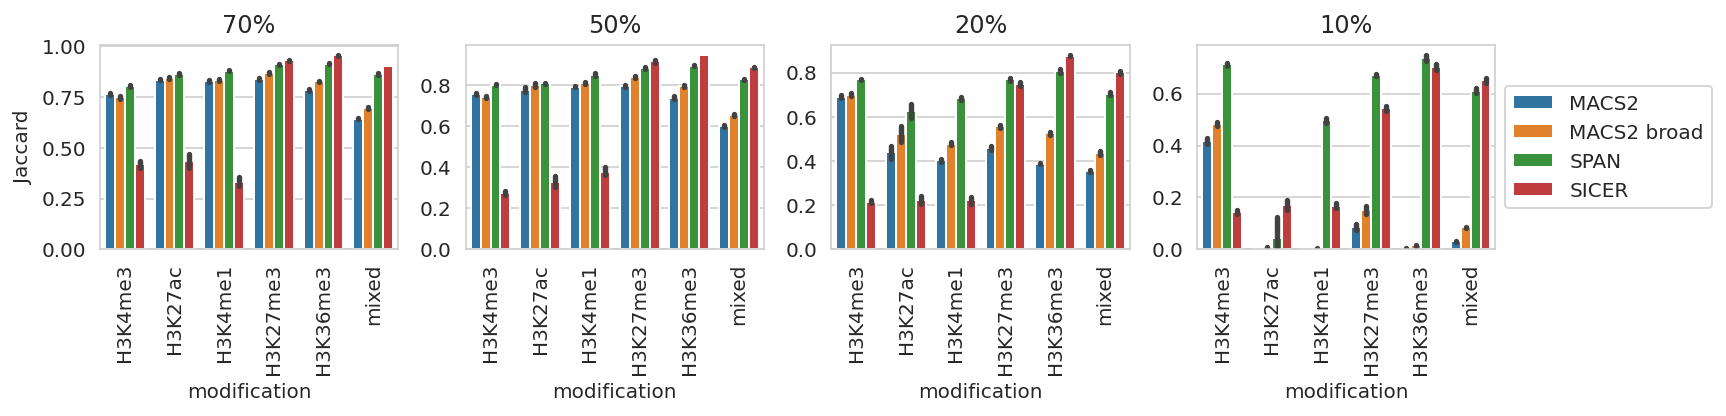

In [97]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 3:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

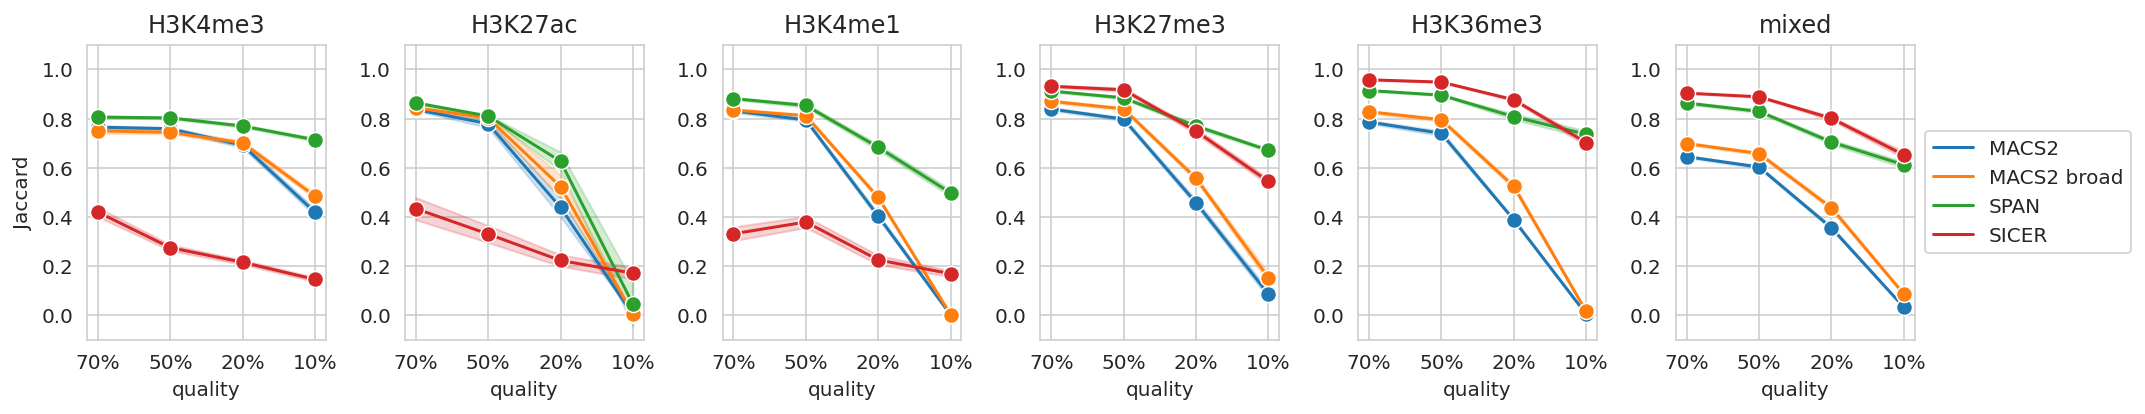

In [98]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df[df['modification']==m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='sd', marker='o', markersize=8)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

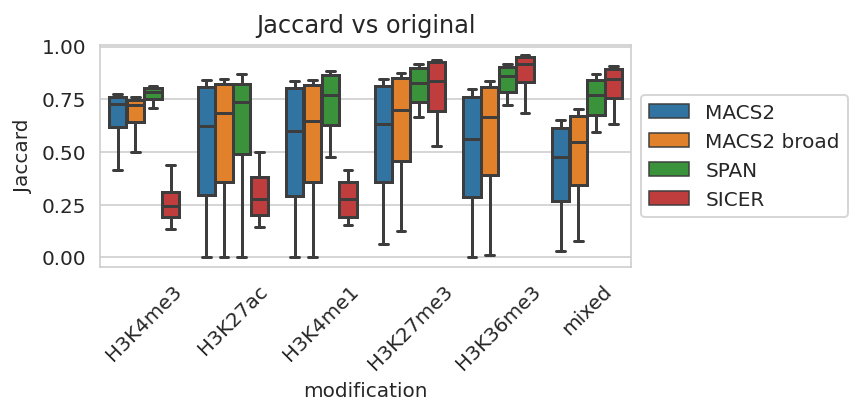

In [106]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=df,
                        x='modification', y='Jaccard', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Jaccard vs original')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [100]:
t = []
for (m, n, tool), dft in tqdm(df.groupby(['modification', 'n', 'tool'])):
    print(m, n, tool)
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc

  0%|          | 0/120 [00:00<?, ?it/s]

H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SICER
H3K27ac 1 SPAN
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SICER
H3K27ac 2 SPAN
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SICER
H3K27ac 3 SPAN
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SICER
H3K27ac 4 SPAN
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SICER
H3K27ac 5 SPAN
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 SICER
H3K27me3 1 SPAN
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 SICER
H3K27me3 2 SPAN
H3K27me3 3 MACS2
H3K27me3 3 MACS2 broad
H3K27me3 3 SICER
H3K27me3 3 SPAN
H3K27me3 4 MACS2
H3K27me3 4 MACS2 broad
H3K27me3 4 SICER
H3K27me3 4 SPAN
H3K27me3 5 MACS2
H3K27me3 5 MACS2 broad
H3K27me3 5 SICER
H3K27me3 5 SPAN
H3K36me3 1 MACS2
H3K36me3 1 MACS2 broad
H3K36me3 1 SICER
H3K36me3 1 SPAN
H3K36me3 2 MACS2
H3K36me3 2 MACS2 broad
H3K36me3 2 SICER
H3K36me3 2 SPAN
H3K36me3 3 MACS2
H3K36me3 3 MACS2 broad
H3K36me3 3 SICER
H3K36me3 3 SPAN
H3K36me3 4 MACS2
H3K36me3 4 MACS2 broad
H3K36me3 4 SICER
H3K36me3 4 SPA

,modification,n,tool,AUC
0,H3K27ac,1,MACS2,0.357347
1,H3K27ac,1,MACS2 broad,0.379473
2,H3K27ac,1,SICER,0.172568
3,H3K27ac,1,SPAN,0.407712
4,H3K27ac,2,MACS2,0.381528
...,...,...,...,...
115,mixed,4,SPAN,0.494560
116,mixed,5,MACS2,0.288024
117,mixed,5,MACS2 broad,0.327017
118,mixed,5,SICER,0.537494


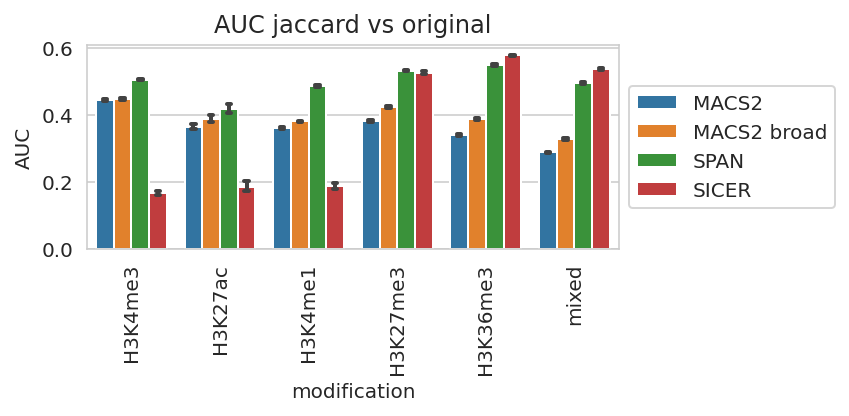

In [107]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs original')
g_results = sns.barplot(data=dfjaccardauc,
                        x='modification', y='AUC',
                        hue='tool',
                        ax=ax,
                        capsize=.05, errwidth=2,
                        order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        )
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


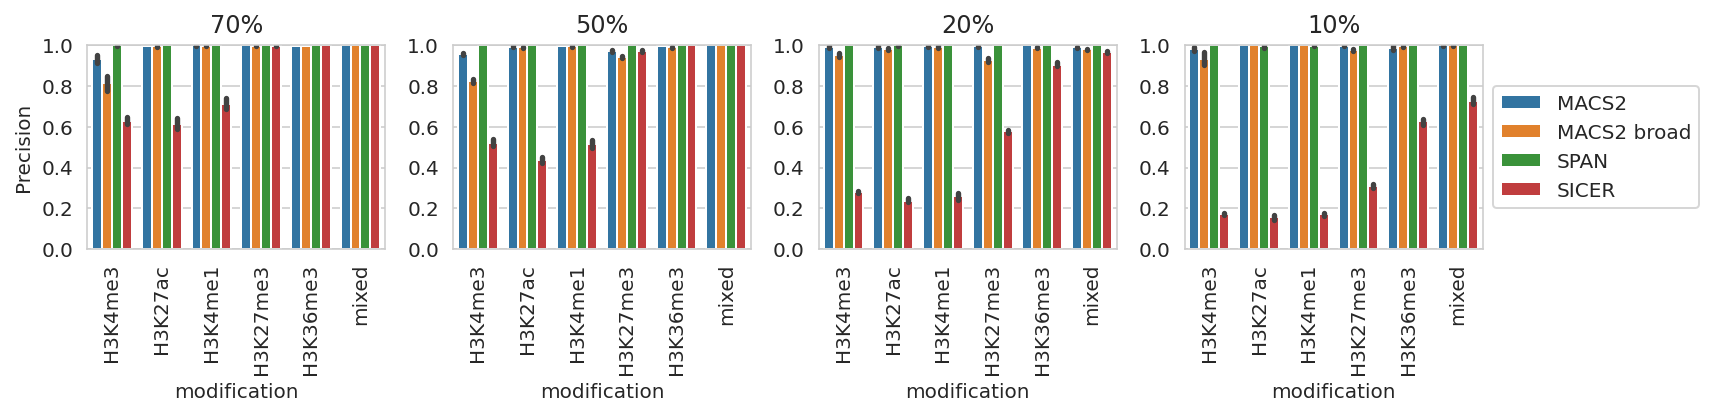

Recall


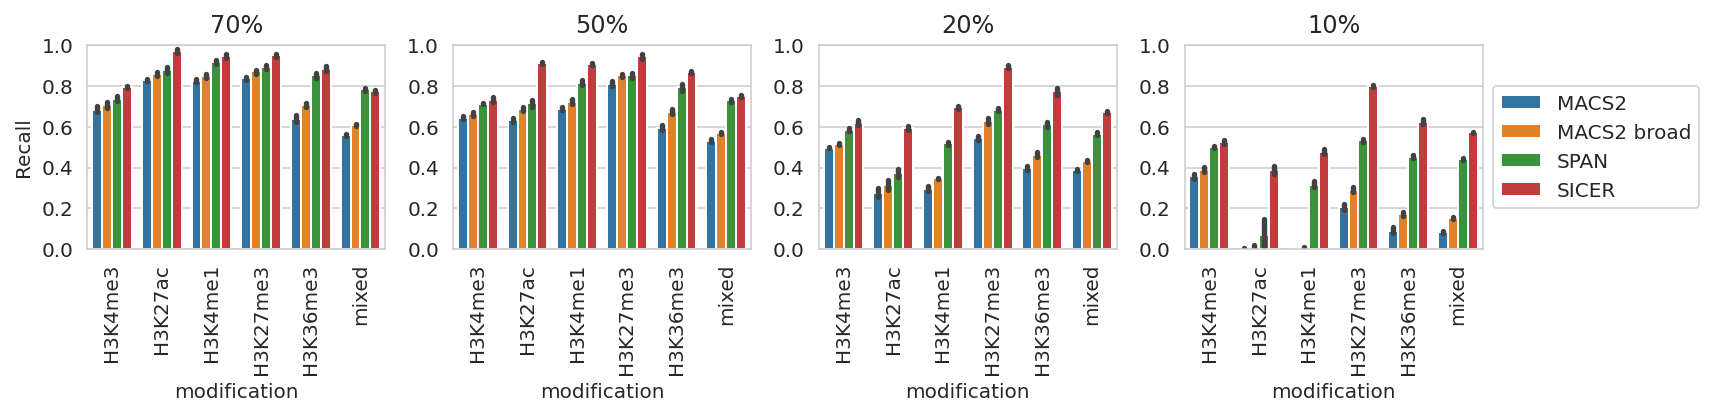

F1


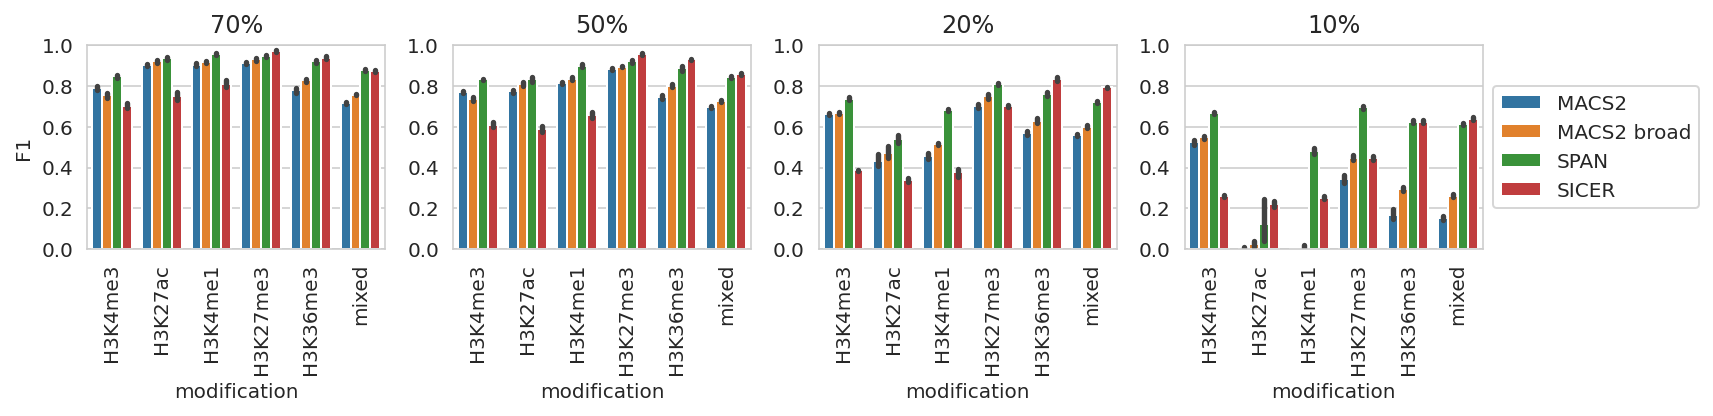

In [102]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
    for i, q in enumerate(df['quality'].unique()):
        ax = axs[i]
        sns.barplot(data=df[df['quality']==q], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == 3:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

  0%|          | 0/6 [00:00<?, ?it/s]

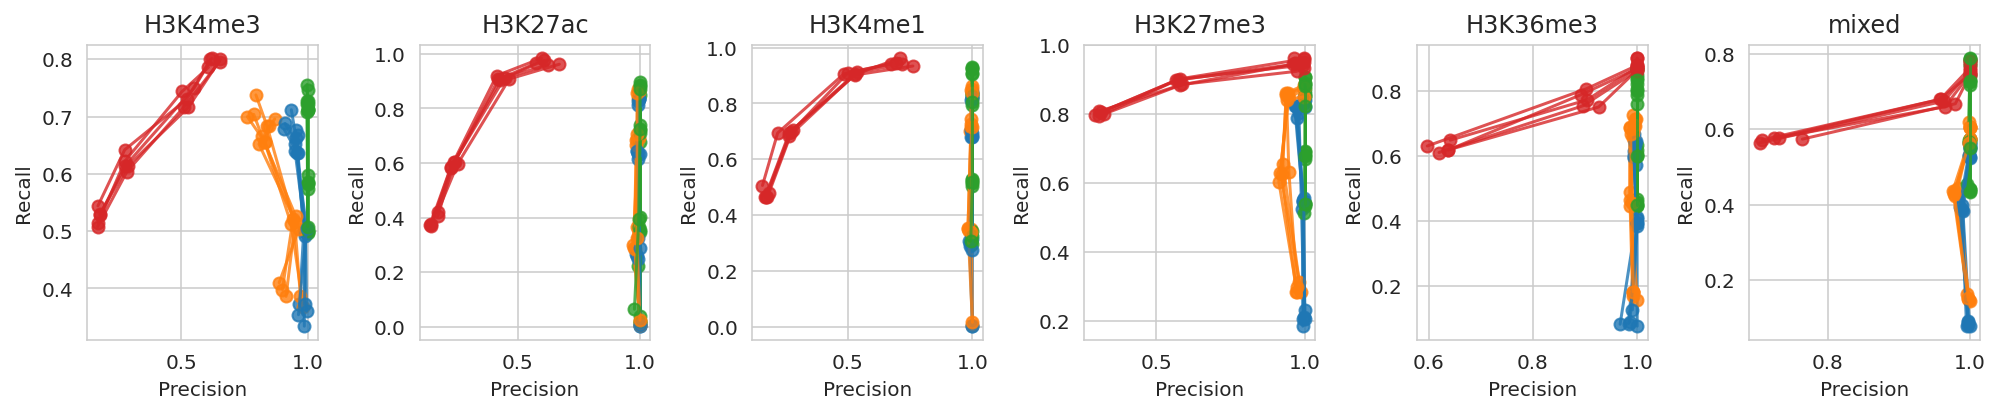

In [103]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df[df['modification'] == m].groupby(['n', 'tool']):
        dft = dft[dft['Recall'] + dft['Precision'] > 0].copy()
        dft.sort_values(by=['Recall', 'multiplier'], inplace=True)
        ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [104]:
t = []
for (m, n, tool), dft in tqdm(df.groupby(['modification', 'n', 'tool'])):
    print(m, n, tool)
    ap = 0
    rprev = 0
    pprev = 0
    for _, row in dft[dft['Recall'] + dft['Precision'] > 0].sort_values(by=['Recall', 'multiplier']).iterrows():
        ap += (row['Recall'] - rprev) * (row['Precision'] + pprev) / 2
        rprev, pprev = row['Recall'], row['Precision']
    t.append((m, n, tool, ap))
dfap = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AP'])
dfap

  0%|          | 0/120 [00:00<?, ?it/s]

H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SICER
H3K27ac 1 SPAN
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SICER
H3K27ac 2 SPAN
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SICER
H3K27ac 3 SPAN
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SICER
H3K27ac 4 SPAN
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SICER
H3K27ac 5 SPAN
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 SICER
H3K27me3 1 SPAN
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 SICER
H3K27me3 2 SPAN
H3K27me3 3 MACS2
H3K27me3 3 MACS2 broad
H3K27me3 3 SICER
H3K27me3 3 SPAN
H3K27me3 4 MACS2
H3K27me3 4 MACS2 broad
H3K27me3 4 SICER
H3K27me3 4 SPAN
H3K27me3 5 MACS2
H3K27me3 5 MACS2 broad
H3K27me3 5 SICER
H3K27me3 5 SPAN
H3K36me3 1 MACS2
H3K36me3 1 MACS2 broad
H3K36me3 1 SICER
H3K36me3 1 SPAN
H3K36me3 2 MACS2
H3K36me3 2 MACS2 broad
H3K36me3 2 SICER
H3K36me3 2 SPAN
H3K36me3 3 MACS2
H3K36me3 3 MACS2 broad
H3K36me3 3 SICER
H3K36me3 3 SPAN
H3K36me3 4 MACS2
H3K36me3 4 MACS2 broad
H3K36me3 4 SICER
H3K36me3 4 SPA

,modification,n,tool,AP
0,H3K27ac,1,MACS2,0.825163
1,H3K27ac,1,MACS2 broad,0.849789
2,H3K27ac,1,SICER,0.202531
3,H3K27ac,1,SPAN,0.892000
4,H3K27ac,2,MACS2,0.646109
...,...,...,...,...
115,mixed,4,SPAN,0.560319
116,mixed,5,MACS2,0.510600
117,mixed,5,MACS2 broad,0.522507
118,mixed,5,SICER,0.396669


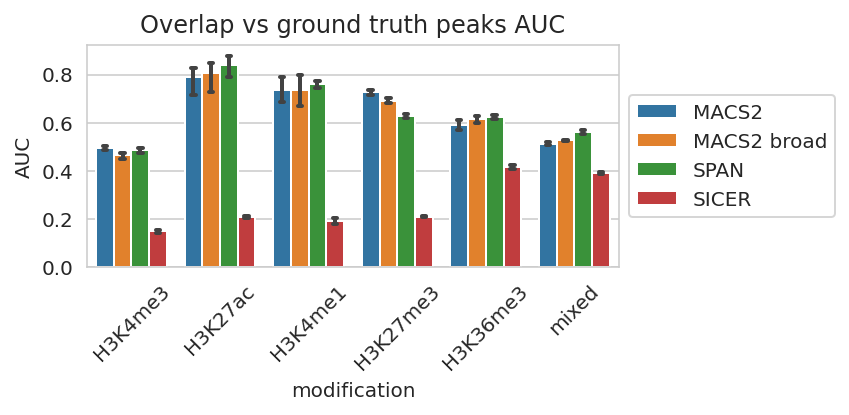

In [105]:
fig = plt.figure(figsize=(6, 3))
g_result = sns.barplot(data=dfap, x="modification", y="AP", hue='tool', capsize=.05, errwidth=2,
                       order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_result.axes.xaxis.set_tick_params(rotation=45)
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs ground truth peaks AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'ap.pdf'), bbox_inches='tight', dpi=300)
plt.show()